**Apply an SVM classifier (for example, from sklearn package) to blobs2.csv dataset and draw the result (both the support vectors and the separation hyperplane).**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
def read_dataset(filename):
    blob = pd.read_csv(filename)
    X = blob.drop('label', axis=1)
    y = blob['label']
    return X, y

In [23]:
X_blob, y_blob = read_dataset('blobs2.csv')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

def draw_svm(X, y, kernel, degree=3):
    # fit the model, don't regularize for illustration purposes
    clf = svm.SVC(kernel=kernel, degree=degree, gamma='scale')
    clf.fit(X, y)

    plt.scatter(X['x'], X['y'], c=y, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[0])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.show()

**Linear kernel**

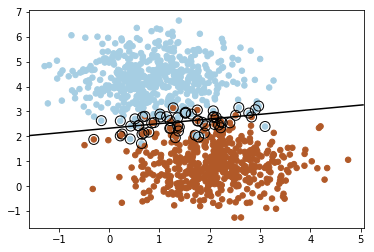

In [25]:
draw_svm(X_blob, y_blob, 'linear')

**Polynomial kernel, degree 2**

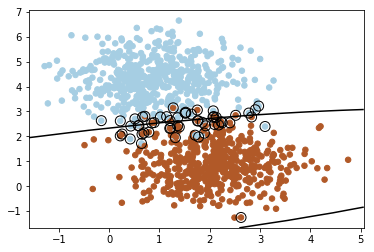

In [26]:
draw_svm(X_blob, y_blob, 'poly', 2)

**Polynomial kernel, degree 3**

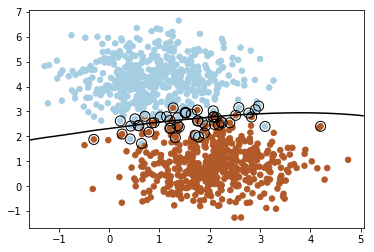

In [27]:
draw_svm(X_blob, y_blob, 'poly')

**Polynomial kernel, degree 5**

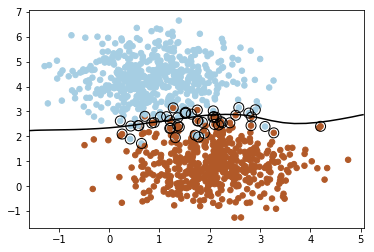

In [28]:
draw_svm(X_blob, y_blob, 'poly', 5)

**Radial Basis Function kernel**

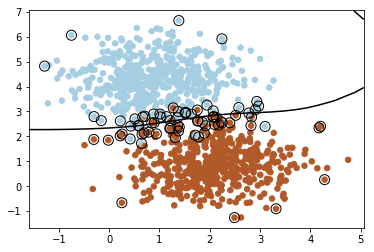

In [17]:
draw_svm('rbf')

**Apply SVM and RandomForest methods to cancer.csv and spam.csv dataset. Compare training time with close performance on validation (20%).**

In [43]:
X_spam, y_spam = read_dataset('spam.csv')

In [3]:
from sklearn.model_selection import train_test_split

def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2)

In [45]:
X_spam_train, X_spam_test, y_spam_train, y_spam_test = split_dataset(X_spam, y_spam)

In [4]:
import time

def measure_time(f):
    start = time.time()
    f()
    end = time.time()
    return end - start

In [11]:
from sklearn.preprocessing import LabelEncoder
def measure_train_time(filename, classifier):
    X, y = read_dataset(filename)
    le = LabelEncoder()
    y = le.fit_transform(y)
    X_train, X_test, y_train, y_test = split_dataset(X, y) 
    print('Time: ', measure_time(lambda : classifier.fit(X_train, y_train)))
    print('Score: ', classifier.score(X_test, y_test))

In [12]:
from sklearn.ensemble import RandomForestClassifier

measure_train_time('spam.csv', RandomForestClassifier())

Time:  0.07080817222595215
Score:  0.9446254071661238


c:\users\olga\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
from sklearn import svm
measure_train_time('spam.csv', svm.SVC(kernel='linear', gamma='scale'))

Time:  575.4051265716553
Score:  0.9153094462540716


In [13]:
measure_train_time('cancer.csv', RandomForestClassifier())

Time:  0.0319211483001709
Score:  0.9473684210526315


c:\users\olga\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [16]:
measure_train_time('cancer.csv', svm.SVC(kernel='linear', gamma='scale'))

Time:  1.1337981224060059
Score:  0.9385964912280702


**Implement a Naive Bayesian Classifier with Gaussian features (no need for EM algorithm, sample mean and variance are sufficient for determining the parameters of a feature distribution) and apply it to spam.csv and cancer.csv.**

In [190]:
spam = pd.read_csv('spam.csv')
cancer = pd.read_csv('cancer.csv')

In [191]:
import scipy.stats
from sklearn.model_selection import train_test_split

def mean_and_std(dataset):
    res = dataset.groupby(by='label').agg(['mean', 'std'])
    y_prob = dataset.groupby(by='label').count().iloc[:, 0]
    y_prob /= y_prob.sum()
    res['probability'] = y_prob
    return res

def gaussian(x, mean, stdev):
    return scipy.stats.norm(mean, stdev).pdf(x)

In [192]:
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm_notebook as tqdm
def gauss_naive_bayes(dataset, C=1e200):
    df_train, df_test = train_test_split(dataset)
    mean_std = mean_and_std(df_train)
    X_test = df_test.drop('label', axis=1)
    y_test = df_test['label']
    predicted_probabilities = pd.DataFrame(columns=list(mean_std.index))
    for row in tqdm(range(len(X_test))):
        probs = []
        for label in list(mean_std.index):
            prob = np.float64(C)
            for col in X_test.columns:
                prob *= gaussian(X_test[col].values[row], mean_std[col]['mean'][label],
                                 mean_std[col]['std'][label])
            prob *= mean_std['probability'][label]
            probs.append(prob)
        probs = np.array(probs)
        predicted_probabilities.loc[len(predicted_probabilities)] = probs / probs.sum()
    predicted_probabilities['actual'] = y_test.values
    return predicted_probabilities

**Draw ROC-curves for scaled output probability (the output itself is quite small, so you should scale it in a way that sums up to 1 for a specific datapoint across all classes).**

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline
def draw_curve(curve):
    plt.plot(curve[0], curve[1])
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")

In [194]:
spam_prob = gauss_naive_bayes(spam)

c:\users\olga\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


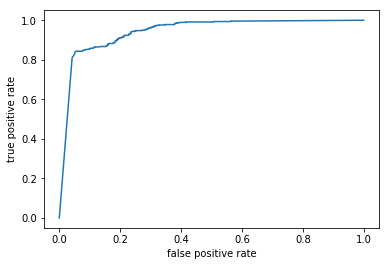

In [196]:
from sklearn.metrics import roc_curve
valid = spam_prob.dropna()
spam_curve = roc_curve(valid['actual'], valid[1])
draw_curve(spam_curve)

In [197]:
cancer_prob = gauss_naive_bayes(cancer)

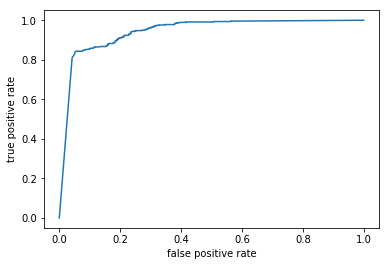

In [198]:
cancer_curve = roc_curve(cancer_prob['actual'], cancer_prob['M'], pos_label='M')
draw_curve(spam_curve)

**Implement a Naive Bayesian Classifier with discrete features, i.e., numbers for dictionary words in the text in smsspam.csv dataset. So, if your dictionary is N words, each datapoint will have N features. Stemming is advised. Draw ROC-curves for scaled output probability.**

In [199]:
smsspam = pd.read_csv('smsspam.csv')

In [200]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

ps = PorterStemmer()
smsspam['text'] = smsspam['text'].apply(lambda text : list(map(ps.stem, word_tokenize(text))))

In [201]:
from collections import defaultdict
def create_dict(df):
    dictionary = defaultdict(lambda: defaultdict(int))

    for i in range(len(df)):
        for word in df['text'].values[i]:
            dictionary[word][df['label'].values[i]] += 1
            dictionary[word]['all'] += 1

    return dictionary

In [202]:
def get_y_prob(dataset):
    y_count = dataset.groupby(by='label').count()
    y_count['prob'] = y_count['text'] / y_count['text'].values.sum()
    return y_count

In [216]:
from tqdm import tqdm_notebook as tqdm
def naive_bayes_word_count(dataset, C=1e200):
    df_train, df_test = train_test_split(dataset)
    y_prob = get_y_prob(df_train)
    dictionary = create_dict(df_train)
    X_test = df_test.drop('label', axis=1)
    y_test = df_test['label']
    predicted_probabilities = pd.DataFrame(columns=list(y_prob.index))
    label_total_count = {}
    for label in y_prob.index:
        label_total_count[label] = sum([dictionary[w][label] for w in dictionary.keys()])
        
    print(label_total_count)
    for row in tqdm(range(len(X_test))):
        probs = {}
        for label in y_prob.index:
            prob = np.float64(C)
            for word in X_test['text'].values[row]:
                if word not in dictionary:
                    continue
                prob *= np.float64(dictionary[word][label] + 1)  / (label_total_count[label] + len(y_prob.index))
            prob *= y_prob.loc[label, 'prob']
            probs[label] = prob
        s = sum(probs.values())
        probs = {k: v / s for k, v in probs.items()}
        predicted_probabilities = predicted_probabilities.append(pd.Series(probs), ignore_index=True)
    predicted_probabilities['actual'] = y_test.values
    return predicted_probabilities

In [217]:
sms_prob = naive_bayes_word_count(smsspam)

{'ham': 62454, 'spam': 16140}


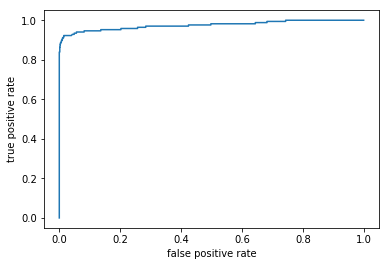

In [218]:
sms_curve = roc_curve(sms_prob['actual'], sms_prob['spam'], pos_label='spam')
draw_curve(sms_curve)